In [1]:
## Import all the packages
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn.manifold import TSNE

In [4]:
## Read derived features data for customers
customer_features = pd.read_csv('output/Final_transaction_derived_features_across_users.csv')

In [5]:
## display top 2 rows
customer_features.head(2)

,client_id,total_spending,avg_transaction,transaction_count,Chip Transaction,Online Transaction,Swipe Transaction,past_3_months_sum,past_6_months_sum,past_9_months_sum,...,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,debt_to_income_ratio
0,0,50852.09,47.703649,1066,958,89,19,15724.66,28900.12,43981.00,...,Male,858 Plum Avenue,43.59,-70.33,29237.0,59613.0,36199.0,763,4,0.607233
1,1,29110.22,35.894229,811,0,327,484,9740.26,17605.51,25469.33,...,Female,113 Burns Lane,30.44,-87.18,22247.0,45360.0,14587.0,704,3,0.321583


## Data Processing
The dataset contains both numerical and categorical features. To facilitate analysis, we will separate these into distinct lists. For now we only use numerical features for clustering. We can also use the categorical features, we need to apply encoding techniques to transform them into numerical representations, enabling their integration with the numerical features for clustering

In [6]:
# Extract numerical features
numerical_features = customer_features.select_dtypes(include=['number']).columns.tolist()

# Extract categorical features
categorical_features = customer_features.select_dtypes(include=['object', 'category']).columns.tolist()

In [7]:
## For inital clustering only considering the numerical features
clustering_df = customer_features[numerical_features]

## check unique number if users
print (clustering_df['client_id'].nunique())

# null values across columns
null_columns = clustering_df.isnull().sum()

# Print results
print("Columns with null values:")
print(null_columns[null_columns > 0])

1206
Columns with null values:
Series([], dtype: int64)


In [8]:
## Display the top 2 rows
clustering_df.head(2)

,client_id,total_spending,avg_transaction,transaction_count,Chip Transaction,Online Transaction,Swipe Transaction,past_3_months_sum,past_6_months_sum,past_9_months_sum,...,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,debt_to_income_ratio
0,0,50852.09,47.703649,1066,958,89,19,15724.66,28900.12,43981.00,...,1986,3,43.59,-70.33,29237.0,59613.0,36199.0,763,4,0.607233
1,1,29110.22,35.894229,811,0,327,484,9740.26,17605.51,25469.33,...,1976,4,30.44,-87.18,22247.0,45360.0,14587.0,704,3,0.321583


## Feature Selection and Correlation Handling
To enhance clustering efficiency, we will remove highly correlated features, as the dataset includes numerous derived variables. Additionally, the client_id column will be excluded from the dataframe as it is not relevant for clustering. A correlation threshold of 0.9 (high correlation) will be used to identify and drop features, though this threshold can be fine-tuned to determine the optimal value for the analysis

In [9]:
# Select numerical features from the dataframe, excluding the 'client_id' column as it is not relevant for clustering
numerical_features = clustering_df.select_dtypes(include=['number']).drop(columns=['client_id'])

# Calculate the correlation matrix for the numerical features
correlation_matrix = numerical_features.corr()

# Identify highly correlated features (absolute correlation > 0.9)
# Set diagonal values (self-correlations) to False to avoid dropping all features
high_correlation = correlation_matrix.abs() > 0.9
np.fill_diagonal(high_correlation.values, False)  # Ignore diagonal

# List columns to drop based on high correlation with other features
drop_features = [col for col in correlation_matrix.columns if any(high_correlation[col])]

# Drop the highly correlated features from the numerical feature set
numerical_features = numerical_features.drop(columns=drop_features)

# Data Standardization & Dimensionality Reduction

Standardizing numberical features and use PCA to reduce the data Dimensionality

In [10]:
# Data Standardization
# Standardizing the data by zero-mean and unit variance to ensure unbiased clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Dimensionality Reduction using PCA
# PCA to reduce the dimensionality of the features
# The number of components is set to retain 95% of the variance
pca = PCA(n_components=0.95)
reduced_features = pca.fit_transform(scaled_features)

## Clustering

Determining Optimal Number of Clusters .Using the Elbow Method and Silhouette Score to determine the optimal number of clusters




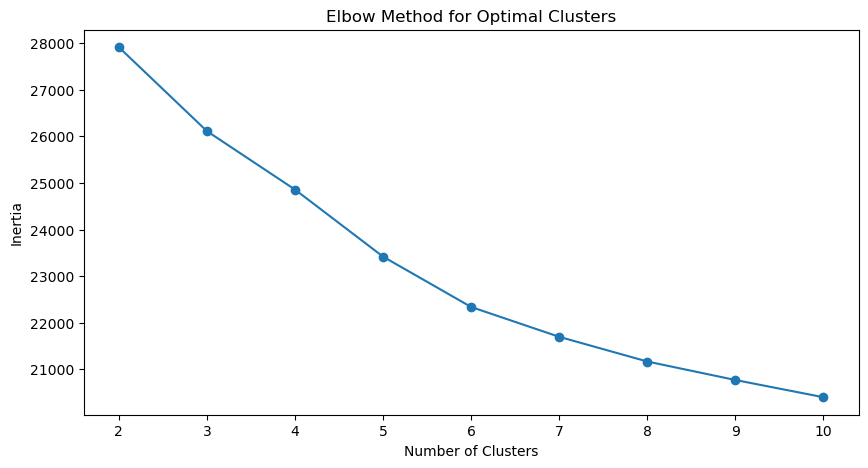

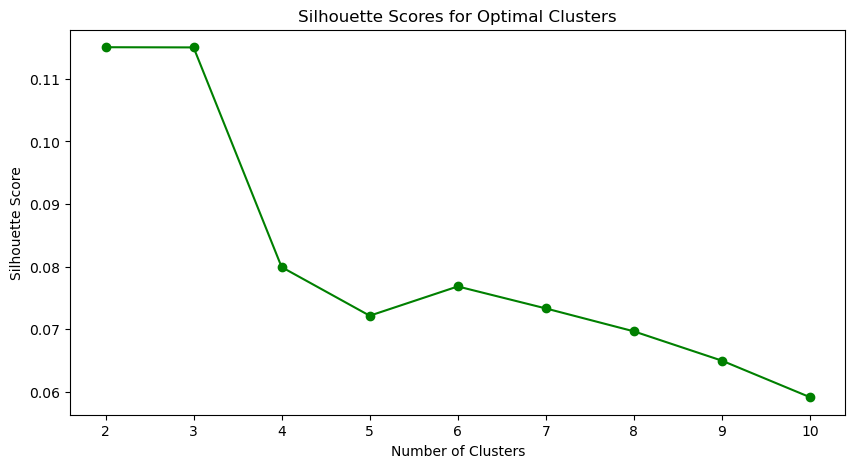

In [11]:
# Determining Optimal Number of Clusters
# Using the Elbow Method and Silhouette Score to determine the optimal number of clusters
inertia = []  # List to store inertia values
silhouette_scores = []  # List to store silhouette scores
range_clusters = range(2, 11)  # Exploring number of clusters from 2 to 10

# Loop through possible cluster sizes and calculate inertia and silhouette scores
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(reduced_features)  # Fit the model on the reduced features
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(reduced_features, kmeans.labels_))  # Append silhouette score

# Elbow Method Plot to visually identify the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Silhouette Score Plot to assess the cohesion and separation of clusters
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


Based on the two graphs, it seems that the data points lack clear separation, as indicated by the low silhouette scores, suggesting significant overlap between clusters. The Elbow Method identifies the number of clusters by measuring the sum of squared distances from data points to their assigned cluster centers, but it doesn't assess cluster quality. The Silhouette Score, which evaluates cohesion and separation, is low, indicating mixed clusters. We chose 6 clusters as the optimal number, balancing inertia reduction and acceptable separation

In [12]:
# optimal number of clusters
optimal_clusters = 6

In [13]:
# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(reduced_features)

# Assign cluster labels to original DataFrame
customer_features['cluster'] = clusters

## Visualizing clusters using t-SNE

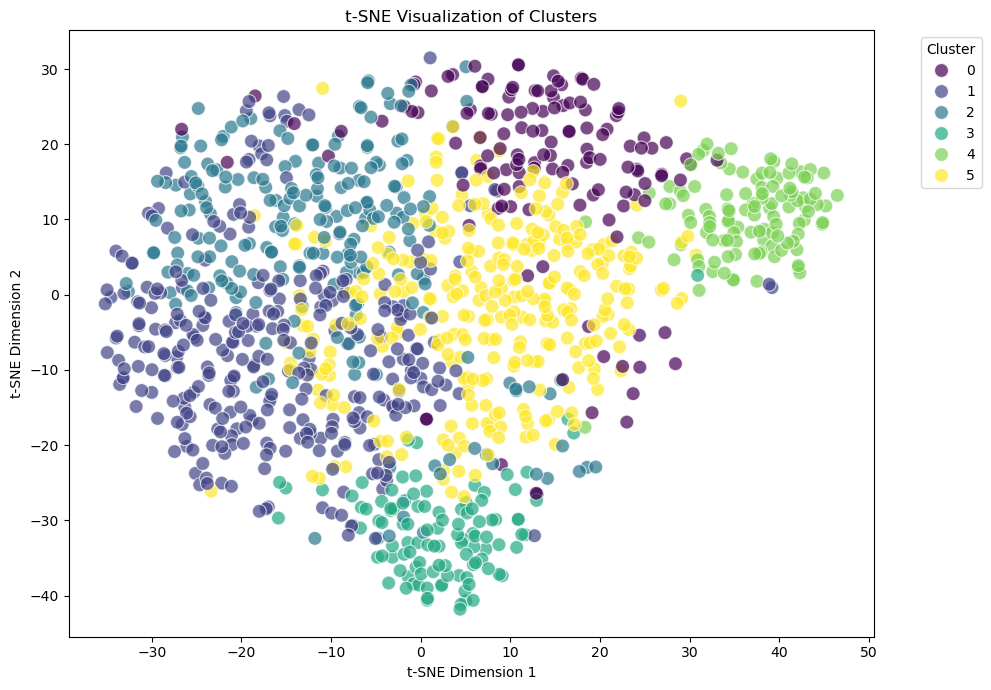

In [14]:
# Apply t-SNE for Dimensionality Reduction
# Reduce the dimensions of the data to 2 components for better visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_2d = tsne.fit_transform(reduced_features)

# Add the t-SNE components to the customer features DataFrame
customer_features['tsne_1'] = reduced_2d[:, 0]
customer_features['tsne_2'] = reduced_2d[:, 1]

# Visualize the Clusters using t-SNE
# Scatter plot to visualize the customer segments (clusters) in 2D space
plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', palette='viridis', data=customer_features, s=100, alpha=0.7)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
## display top 1 row to check final output
numerical_features.head(1)

,avg_transaction,transaction_count,Chip Transaction,Online Transaction,Swipe Transaction,rate_of_change_3m,spending_volatility_3m,spending_volatility_6m,spending_volatility_9m,num_unique_merchants,...,swipe_transaction_ratio,absolute_change_3m_vs_6m,retirement_age,birth_month,latitude,longitude,total_debt,credit_score,num_credit_cards,debt_to_income_ratio
0,47.703649,1066,958,89,19,2.945873,1091.301137,852.178344,699.248083,134,...,0.017824,2549.2,69,3,43.59,-70.33,36199.0,763,4,0.607233


## Create meaningful profile descriptions for each segment

In [16]:
# Print cluster centroids for insights
cluster_centers = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
centroids_df = pd.DataFrame(cluster_centers, columns=numerical_features.columns)
print("Cluster Centroids:\n", centroids_df)

Cluster Centroids:
    avg_transaction  transaction_count  Chip Transaction  Online Transaction  \
0        68.804287        1065.754565        804.984646          113.420094   
1        36.939240         654.801385        540.248442           37.010407   
2        45.270559         649.599784        533.019263           40.248917   
3        41.007563         921.957753        229.236773           82.527821   
4        39.350140        1458.313561        722.072421          587.863743   
5        39.528254        1230.858491        989.272627           80.482044   

   Swipe Transaction  rate_of_change_3m  spending_volatility_3m  \
0         147.349825           2.003758             1311.221749   
1          77.542536           1.984650              353.584006   
2          76.331604           2.315504              728.288076   
3         610.193159           2.080186              546.175950   
4         148.377397           2.044591              650.538481   
5         161.103820    

### Cluster Profiling Approach

Analyzed the cluster segment data to create meaningful customer profiles by focusing on the following aspects:

1. **Spending Patterns**:

    Evaluated total spending within each cluster, the frequency of transactions, and the average transaction size in monetary terms. This provides insights into how customers allocate their financial resources.
2. **Financial Metrics**:

     Considered per-capita income, debt levels, and credit scores to assess financial health and purchasing power. These factors help identify creditworthiness and potential for banking product adoption.
3. **Transaction Behavior**:

    Examined the mix of transaction types (e.g., chip, online, swipe) to understand customer preferences for different payment methods and their digital adoption levels.
4. **Demographic and Lifestyle Indicators**:

    Incorporated age and retirement age to define profiles aligned with customers’ life stages and anticipated financial needs.
5. **Cluster Naming and Business Targeting**:

    Each cluster was given a descriptive name based on observed patterns to facilitate easy understanding and alignment with targeted marketing or banking product strategies. This helps the business tailor offerings like loans, credit cards, or investment products to suit specific segments.

In [17]:
cluster_profiles = {
    '0': {
        'Clustername': 'High Spenders with Diverse Transactions',
        'Spending': 'Highest total spending ($69,651), average transaction size ($68), and transaction count (1,065)',
        'Transaction Types': 'Predominantly chip-based (~76%), with some online (10%) and swipe transactions (14%)',
        'Demographics': 'Moderate income ($38,863 per capita), higher debt ($112,426), and lower credit scores (702)',
        'Age': 'Average age is 51'
    },
    '1': {
        'Clustername': 'Moderate Spenders with Consistency',
        'Spending': 'Moderate spending ($23,598) and smaller average transactions ($36)',
        'Transaction Types': 'Higher proportion of chip transactions (~79%)',
        'Demographics': 'Lower income ($18,175 per capita), moderate debt ($55,578), and good credit scores (715)',
        'Age': 'Slightly younger demographic (average age 50)'
    },
    '2': {
        'Clustername': 'Value-Conscious Users',
        'Spending': 'Lower spending ($28,521) and moderate transaction counts (659)',
        'Transaction Types': 'Predominantly chip-based, with fewer online and swipe transactions',
        'Demographics': 'Lower income ($20,806 per capita) but relatively low debt ($53,509)',
        'Age': 'Average age is 51'
    },
    '3': {
        'Clustername': 'Mid-Tier Spenders with Frequent Transactions',
        'Spending': 'Mid-level spending ($37,504) and higher transaction counts (915)',
        'Transaction Types': 'Predominantly swipe-based (~65%), with fewer chip transactions',
        'Demographics': 'Moderate income ($22,370 per capita),  moderate debt ($59,842), and good credit scores (720)',
        'Age': 'Younger demographic (average age 49)'
    },
    '4': {
        'Clustername': 'High-Volume Spenders',
        'Spending': 'High spending ($55,620) with many transactions (1,444)',
        'Transaction Types': 'Balanced between chip and online transactions',
        'Demographics': 'Moderate income ($24,012 per capita), moderate debt ($54,292), and average credit scores (702)',
        'Age': 'Slightly older demographic (average age 54)'
    },
    '5': {
        'Clustername': 'Older, Conservative Spenders',
        'Spending': 'Moderate spending ($47,810) with significant chip-based transactions (~81%)',
        'Transaction Types': 'Mostly chip and fewer online or swipe transactions',
        'Demographics': 'Lower debt-to-income ratio (0.94), strong credit scores (724)',
        'Age': 'Oldest group (average age 59)'
    }
}

In [18]:
# Convert the 'Cluster' column to string for merging
customer_features['cluster'] = customer_features['cluster'].astype(str)

# Convert the dictionary into a DataFrame
cluster_df = pd.DataFrame.from_dict(cluster_profiles, orient='index')

# Combine the profile details into a single string for each cluster
cluster_df['Profile'] = cluster_df.apply(lambda row: f"Clustername: {row['Clustername']}; Spending: {row['Spending']}; Transaction Types: {row['Transaction Types']}; Demographics: {row['Demographics']}; Age: {row['Age']}", axis=1)

# Merge the original DataFrame with the profile string column
customer_features = customer_features.merge(cluster_df[['Profile']], left_on='cluster', right_index=True, how='left')

In [20]:
# Define the output folder path
output_folder = "output"

# Check if the folder exists; if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print(f"Output folder '{output_folder}' is ready.")

Output folder 'output' is ready.


In [22]:
## save the final df as csv file for content generation 
customer_features.to_csv('output/customer_features_clustering_details.csv',index=False)

In [ ]:
df =numerical_features.copy()

In [ ]:
from sklearn.ensemble import IsolationForest
df2 = df.copy()

# Model building
model=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.1), max_features=1.0)
model.fit(df2)

# Adding 'scores' and 'anomaly' colums to df
scores=model.decision_function(df2)
anomaly=model.predict(df2)

df2['scores']=scores
df2['anomaly']=anomaly

anomaly = df2.loc[df2['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

# dropping outliers
df2 = df2.drop(anomaly_index, axis = 0).reset_index(drop=True)

# dropping columns that we don't need any more
df2.drop(['scores', 'anomaly'], axis = 1, inplace =True)

In [ ]:
numerical_features = df.copy()

In [ ]:
selected_features = ['total_spending', 'avg_transaction', 'transaction_count', 'credit_score', 'spending_volatility_3m']
df_selected = customer_features[selected_features + ['cluster']]

In [ ]:
# Step 10.2: Pairplot with selected features
sns.pairplot(df_selected, hue='cluster', diag_kind='kde', palette='viridis')
plt.show()

In [ ]:
# Print cluster centroids for insights
cluster_centers = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
centroids_df = pd.DataFrame(cluster_centers, columns=numerical_features.columns)
print("Cluster Centroids:\n", centroids_df)